In [78]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [79]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [119]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import IPython.display as display
import PIL.Image

In [81]:
url = 'cat.jpg'

### carregando rede neural pré-treinada

In [82]:
# modelo de rede neural base inspectionV3 
modelo_base = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [83]:
len(modelo_base.layers)

311

In [84]:
names = ['mixed3', 'mixed5']

In [85]:
modelo_base.input

<KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=None, name=keras_tensor_622>

In [86]:
layers = [modelo_base.get_layer(nome).output for nome in names]
layers

[<KerasTensor shape=(None, None, None, 768), dtype=float32, sparse=False, name=keras_tensor_722>,
 <KerasTensor shape=(None, None, None, 768), dtype=float32, sparse=False, name=keras_tensor_786>]

In [87]:
# aplicando modelo de rede deep dream utilizando o modelo base
modelo_deep_dream = tf.keras.Model(inputs = modelo_base.input, outputs = layers)
modelo_deep_dream.output

[<KerasTensor shape=(None, None, None, 768), dtype=float32, sparse=False, name=keras_tensor_722>,
 <KerasTensor shape=(None, None, None, 768), dtype=float32, sparse=False, name=keras_tensor_786>]

### carregamento e pré-processamento da imagem

In [88]:
imagem = tf.keras.preprocessing.image.load_img(url, target_size=(225,300))

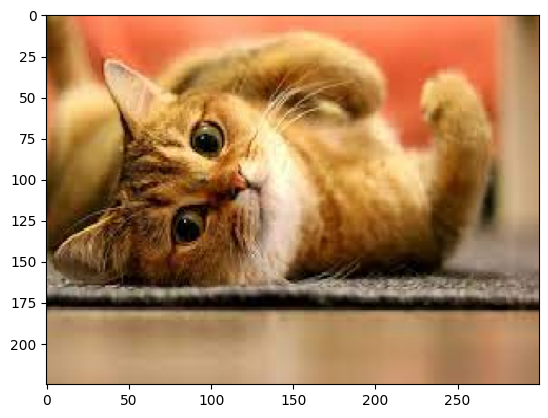

In [89]:
plt.imshow(imagem)

In [90]:
type(imagem)

PIL.Image.Image

In [91]:
print(imagem.size)
print(imagem.mode)
print(len(imagem.mode))


(300, 225)
RGB
3


In [92]:
# imagem = tf.keras.preprocessing.image.array_to_img(imagem)
imagem = tf.keras.preprocessing.image.img_to_array(imagem)

In [93]:
type(imagem)

numpy.ndarray

In [94]:
print("corpo img: ",imagem.shape)
print("min: ",imagem.min())
print("max: ",imagem.max())

corpo img:  (225, 300, 3)
min:  0.0
max:  255.0


In [95]:
#imagem /= 255
imagem = tf.keras.applications.inception_v3.preprocess_input(imagem)

In [96]:
print(imagem.min())
print(imagem.max())

-1.0
1.0


### ativando rede neural

In [97]:
imagem.shape

(225, 300, 3)

In [98]:
imagem_batch = tf.expand_dims(imagem, axis=0)
imagem_batch.shape

TensorShape([1, 225, 300, 3])

In [99]:
ativacoes = modelo_deep_dream.predict(imagem_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [100]:
modelo_deep_dream.outputs

[<KerasTensor shape=(None, None, None, 768), dtype=float32, sparse=False, name=keras_tensor_722>,
 <KerasTensor shape=(None, None, None, 768), dtype=float32, sparse=False, name=keras_tensor_786>]

In [101]:
print(len(ativacoes))
print(ativacoes[1])

2
[[[[2.5548582  0.         0.         ... 0.         0.13796645
    0.5221709 ]
   [0.         0.         0.         ... 0.         0.257734
    0.43472892]
   [1.6578778  0.         0.         ... 0.         0.05920506
    0.38903275]
   ...
   [0.         0.         0.         ... 0.         0.
    0.5214883 ]
   [0.19611442 0.         0.         ... 0.         0.
    0.5863092 ]
   [2.7842088  0.1832839  0.         ... 0.         0.
    0.6978109 ]]

  [[1.4213136  0.         0.         ... 0.         0.
    0.2758419 ]
   [0.         0.         0.         ... 0.         0.09303863
    0.2184309 ]
   [1.3056253  0.39729744 0.         ... 0.         0.21585038
    0.2975735 ]
   ...
   [0.582489   0.         0.         ... 0.         0.
    0.0361563 ]
   [0.         0.         0.         ... 0.         0.
    0.33038336]
   [0.75814843 0.         0.         ... 0.         0.
    0.26853818]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.  

### loss (calculo de errro)

In [121]:
def calculo_erro(imagem, network):
    imagem_batch = tf.expand_dims(imagem, axis=0)
    ativacoes = network(imagem_batch)
    erros = []
    for ativacao in ativacoes:
        media = tf.math.reduce_mean(ativacao)
        erros.append(media)
     # print(erros)    # print(np.shape(erros))    # print(tf.reduce_sum(erros))
    return tf.reduce_sum(erros)

In [112]:
loss = calculo_erro(imagem, modelo_deep_dream)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.7072278>

### elevação do grardiente


In [115]:
@tf.function
def deep_dream(network, imagem, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(imagem)
        erro = calculo_erro(imagem, network)
        
    gradientes = tape.gradient(erro, imagem)
    gradientes /= tf.math.reduce_std(gradientes)
    imagem = imagem + gradientes * learning_rate
    imagem = tf.clip_by_value(imagem, -1,1)
    
    return erro, imagem

In [116]:
def converte_imagem(imagem):
    imagem = 255 * (imagem + 1.0)/2.0
    return tf.cast(imagem, tf.uint8)
    

In [117]:
def executar_deep_dream(network, imagem ,epocas, learning_rate):
    for epoca in range(epocas):
        erro, imagem = deep_dream(network, imagem, learning_rate)
        if epoca % 200 == 0:
            plt.figure(figsize=(15,15))
            plt.imshow(converte_imagem(imagem))
            plt.show()
            print('epoca {}, loss{}'.format(epoca,erro))

### gerando imagens

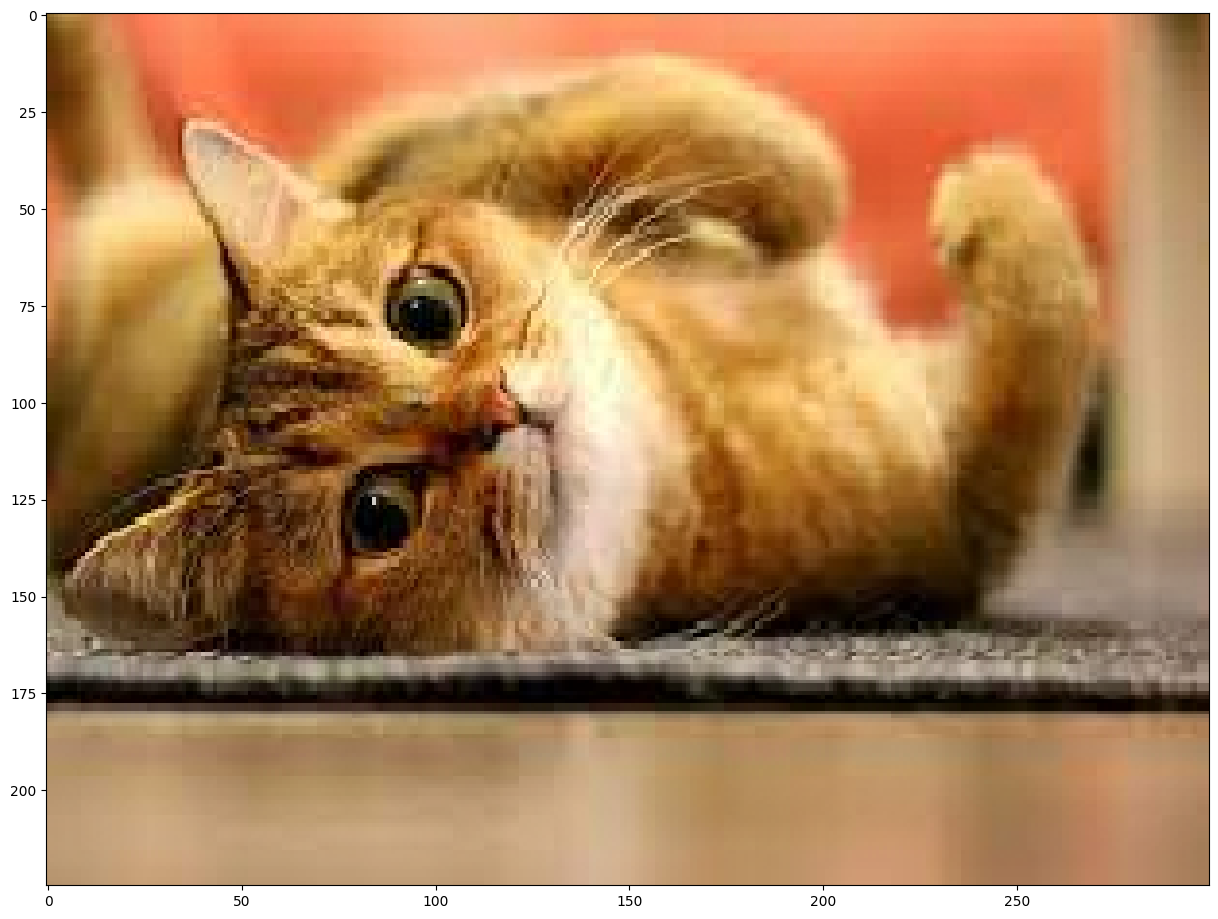

epoca 0, loss0.7072278261184692


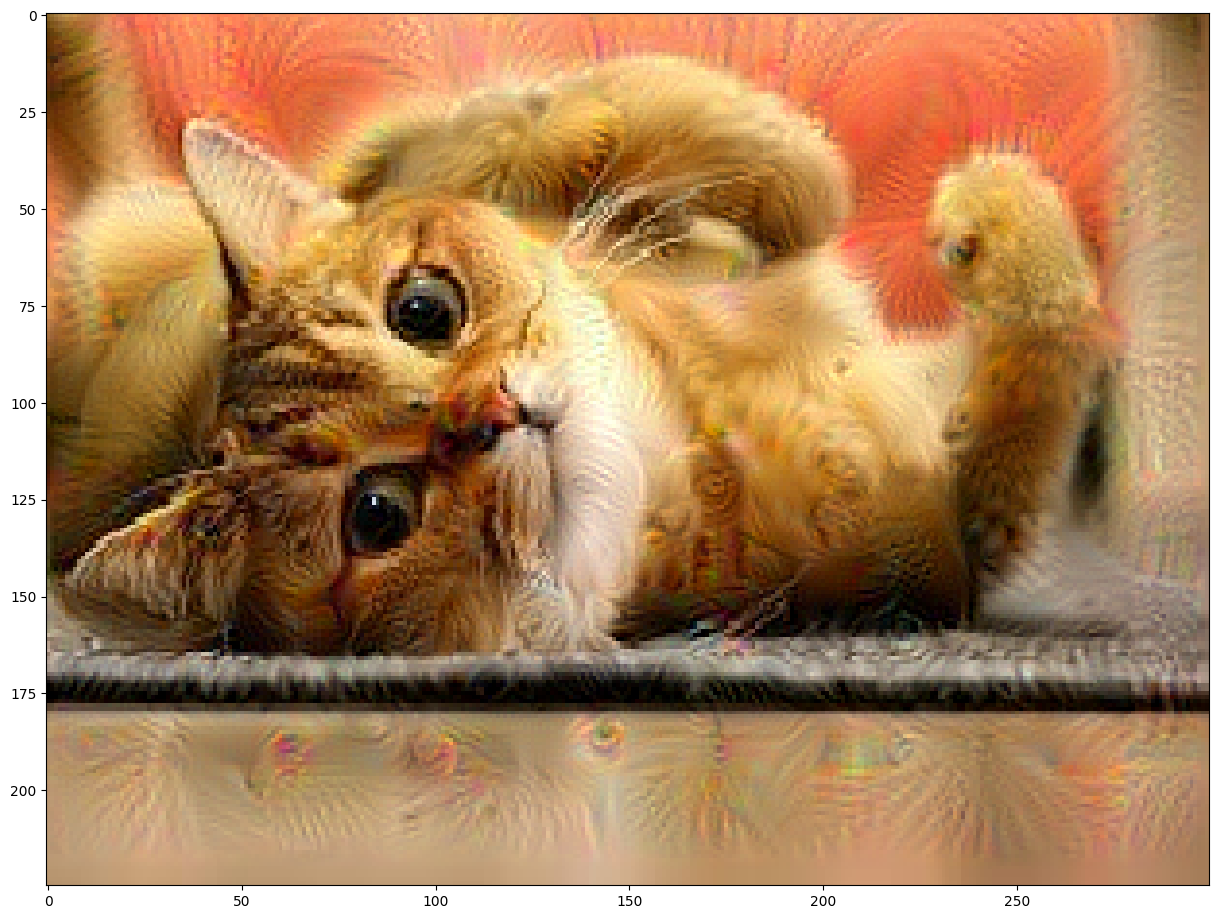

epoca 200, loss1.6787762641906738


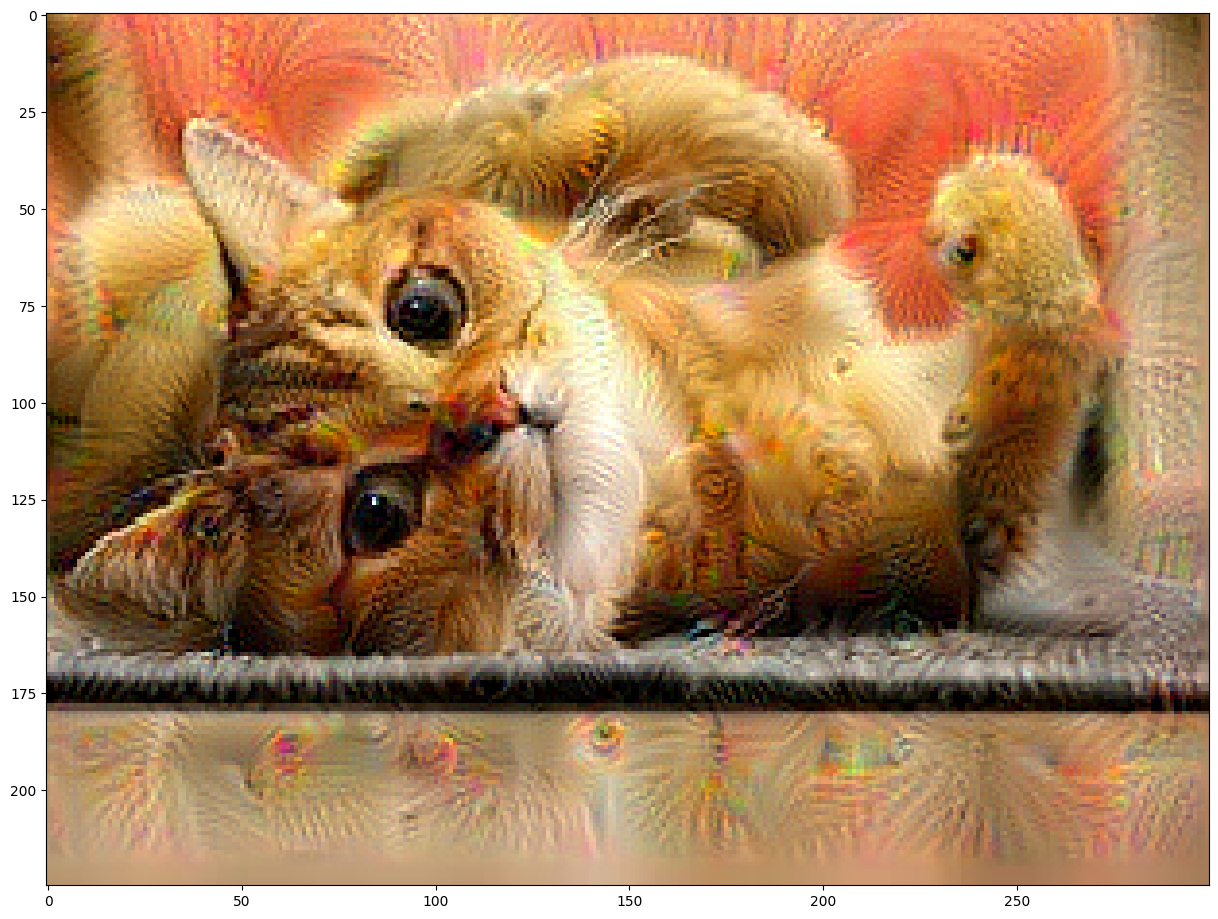

epoca 400, loss1.9481146335601807


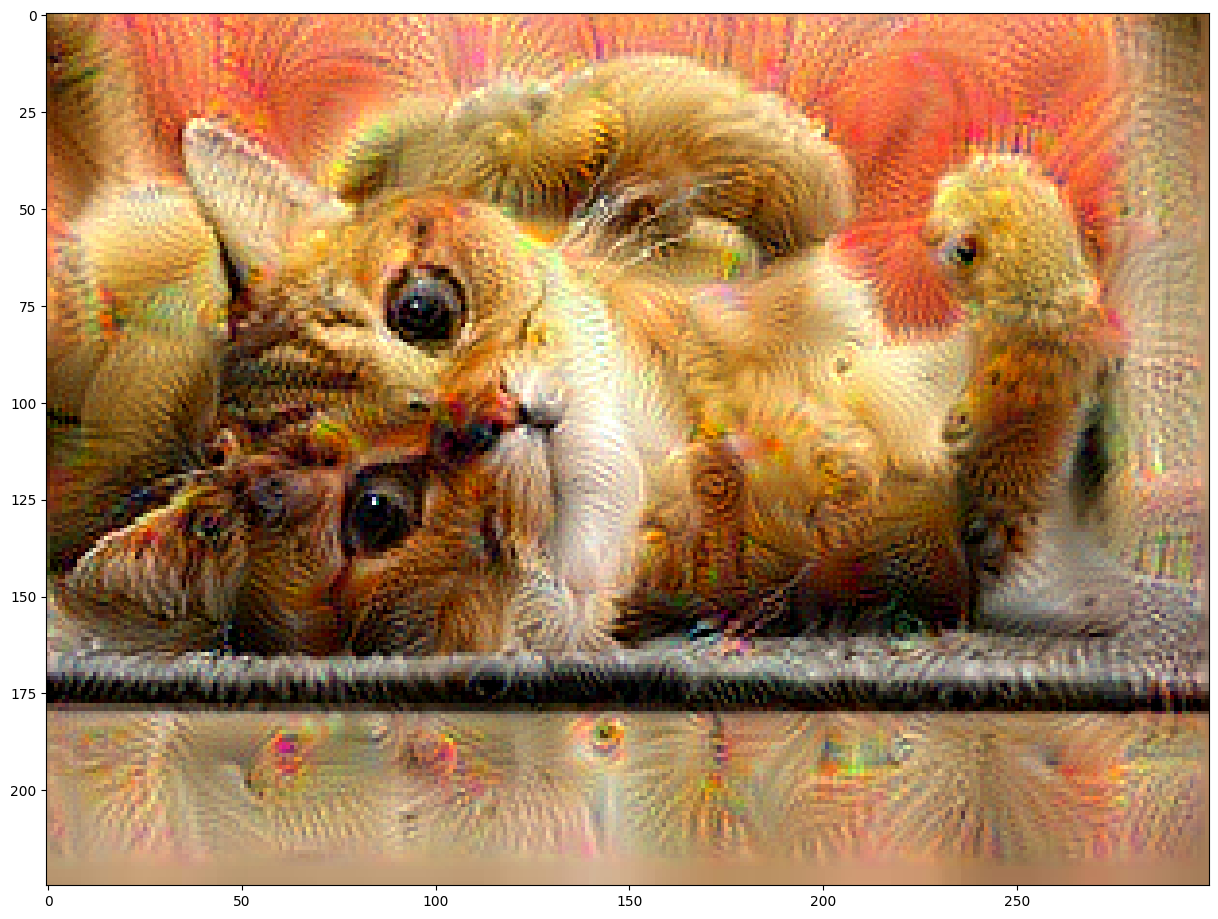

epoca 600, loss2.123577833175659


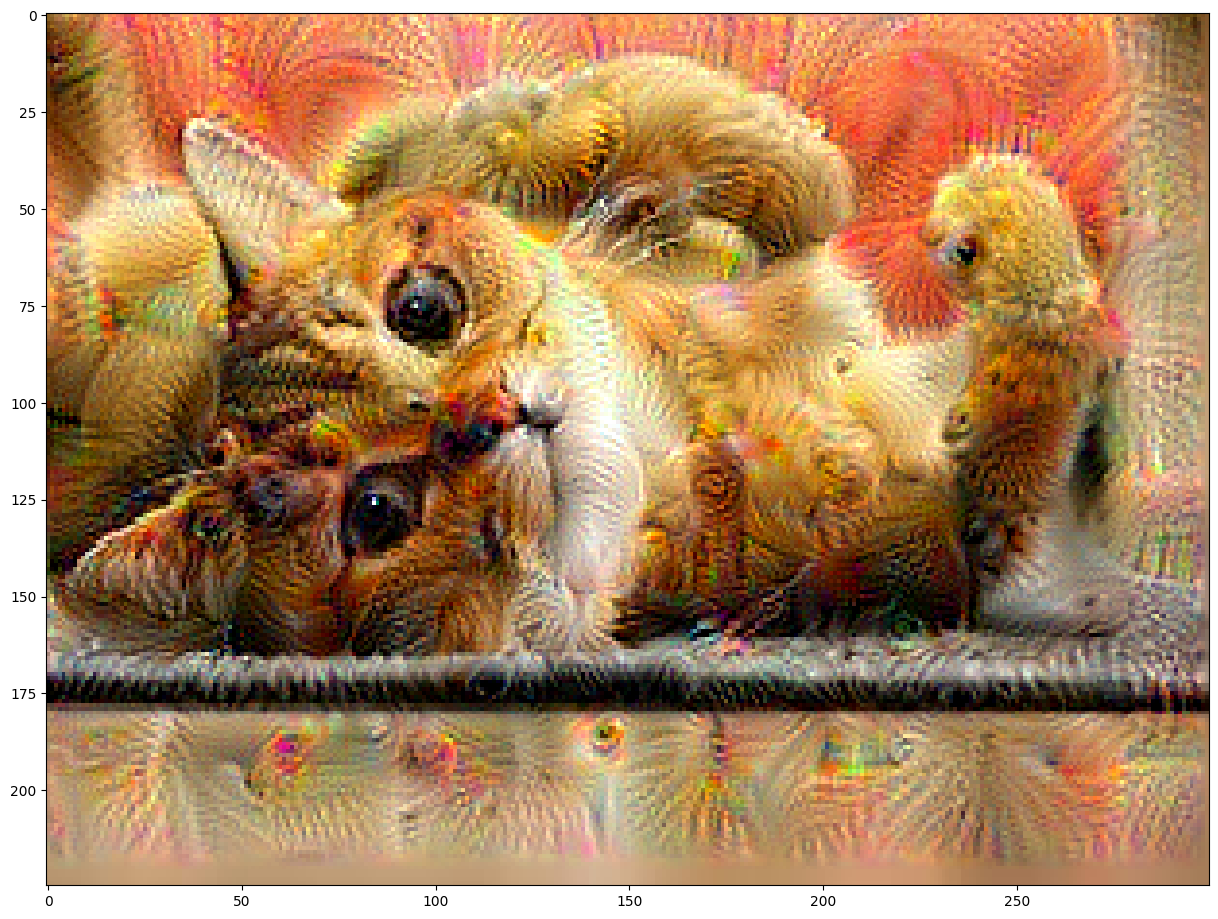

epoca 800, loss2.252565860748291


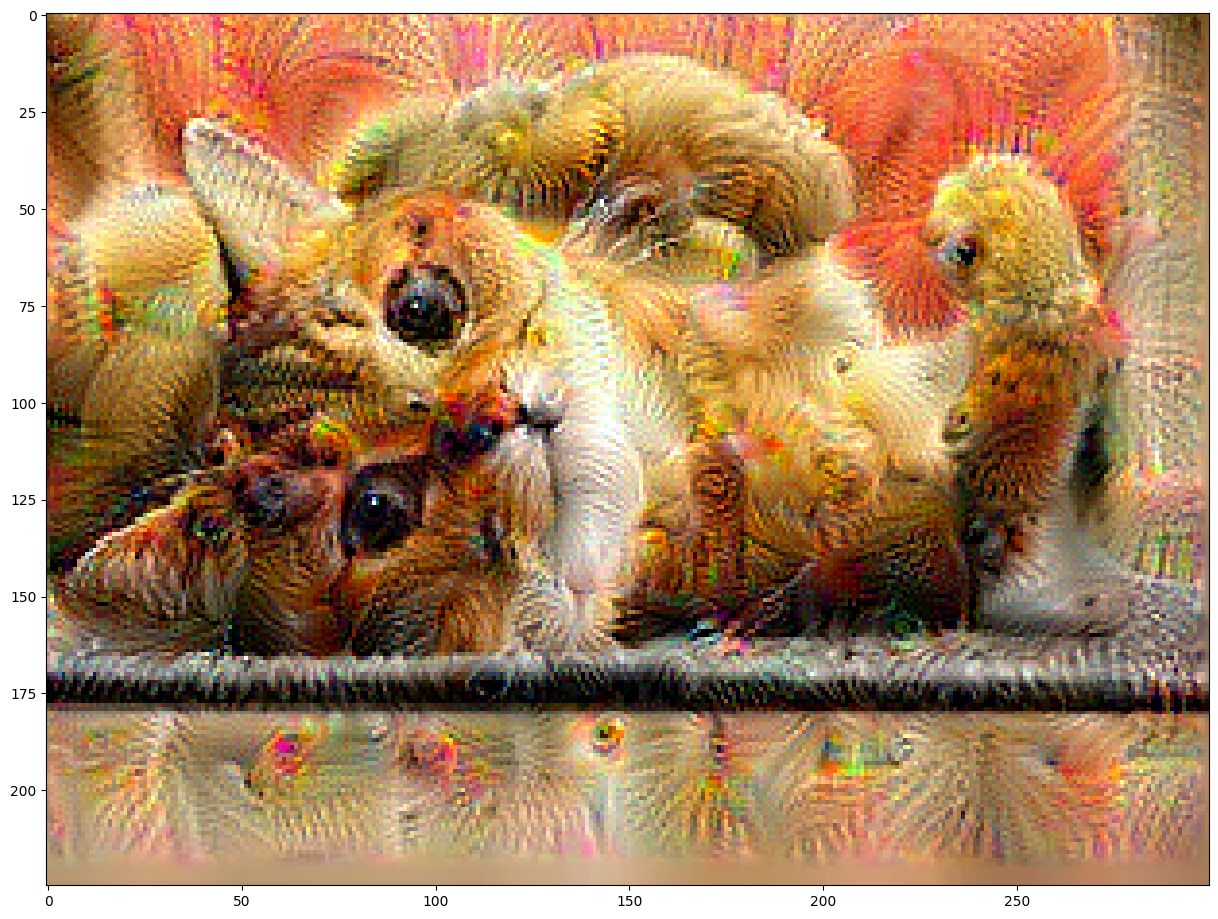

epoca 1000, loss2.3580965995788574


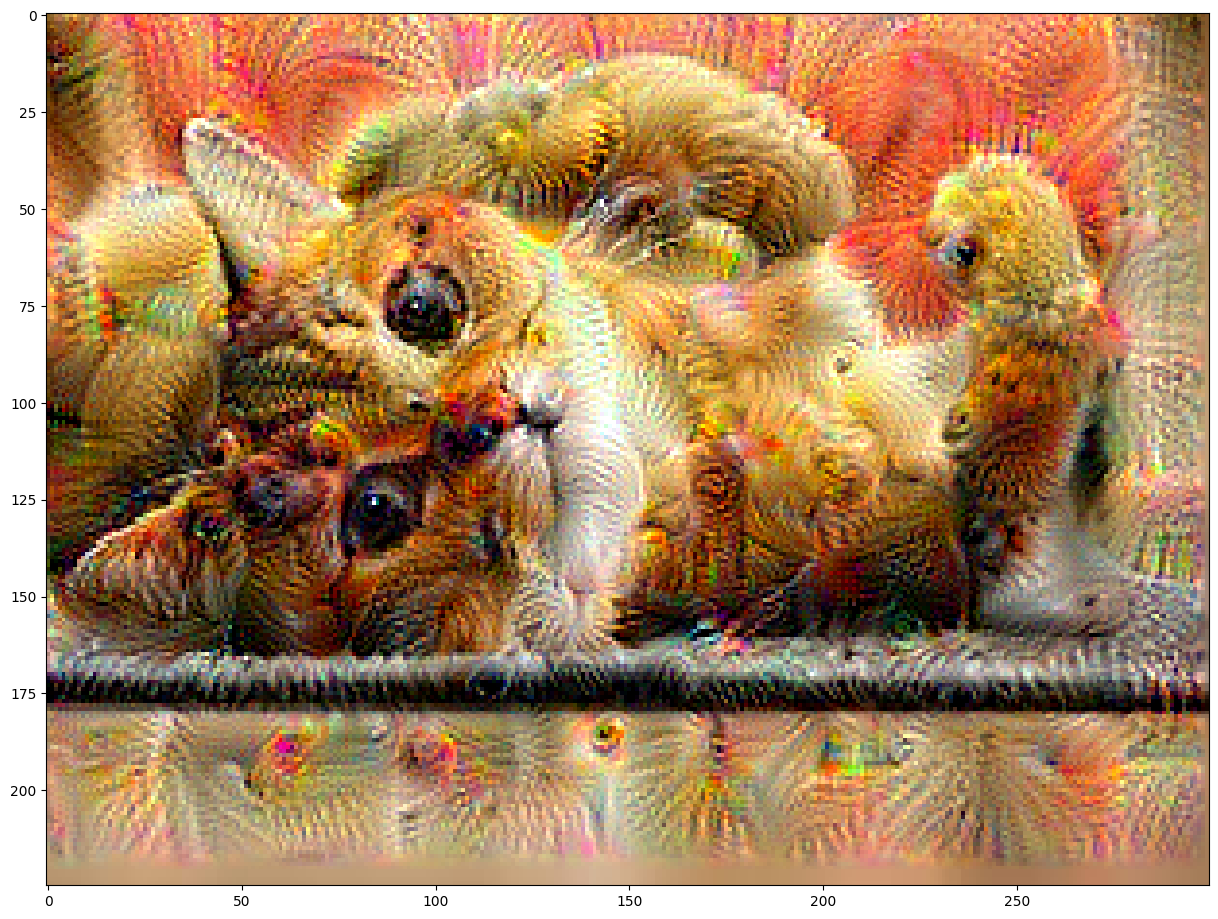

epoca 1200, loss2.445496082305908


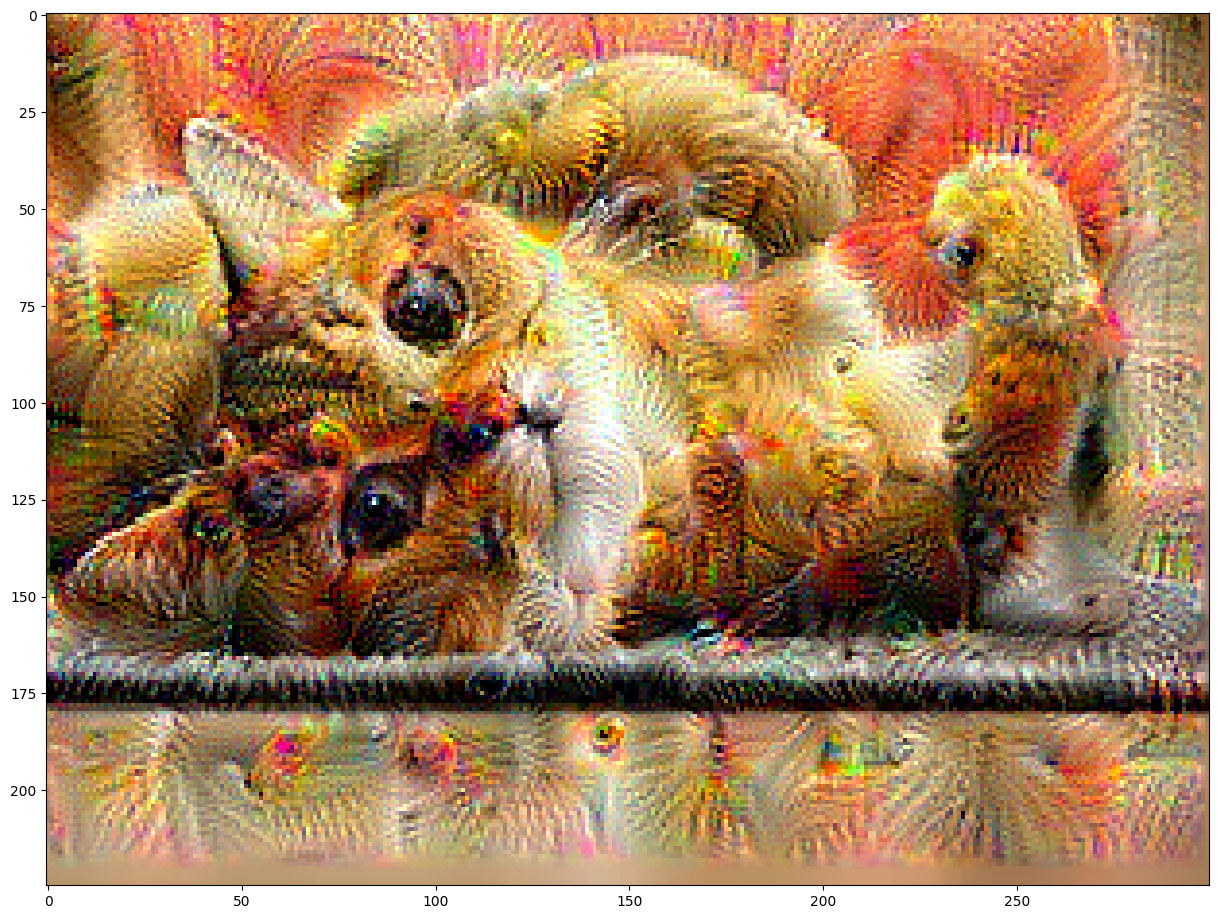

epoca 1400, loss2.5200867652893066


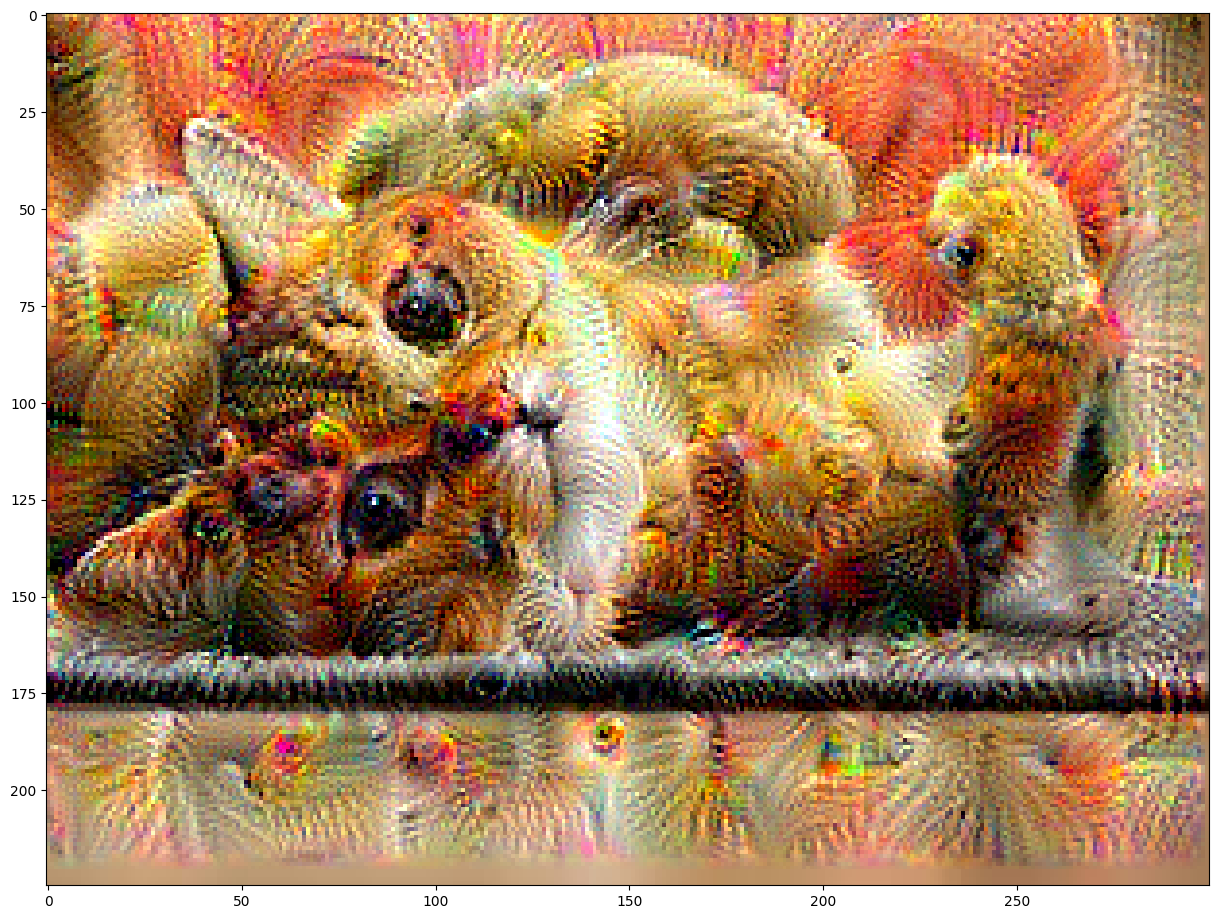

epoca 1600, loss2.587092638015747


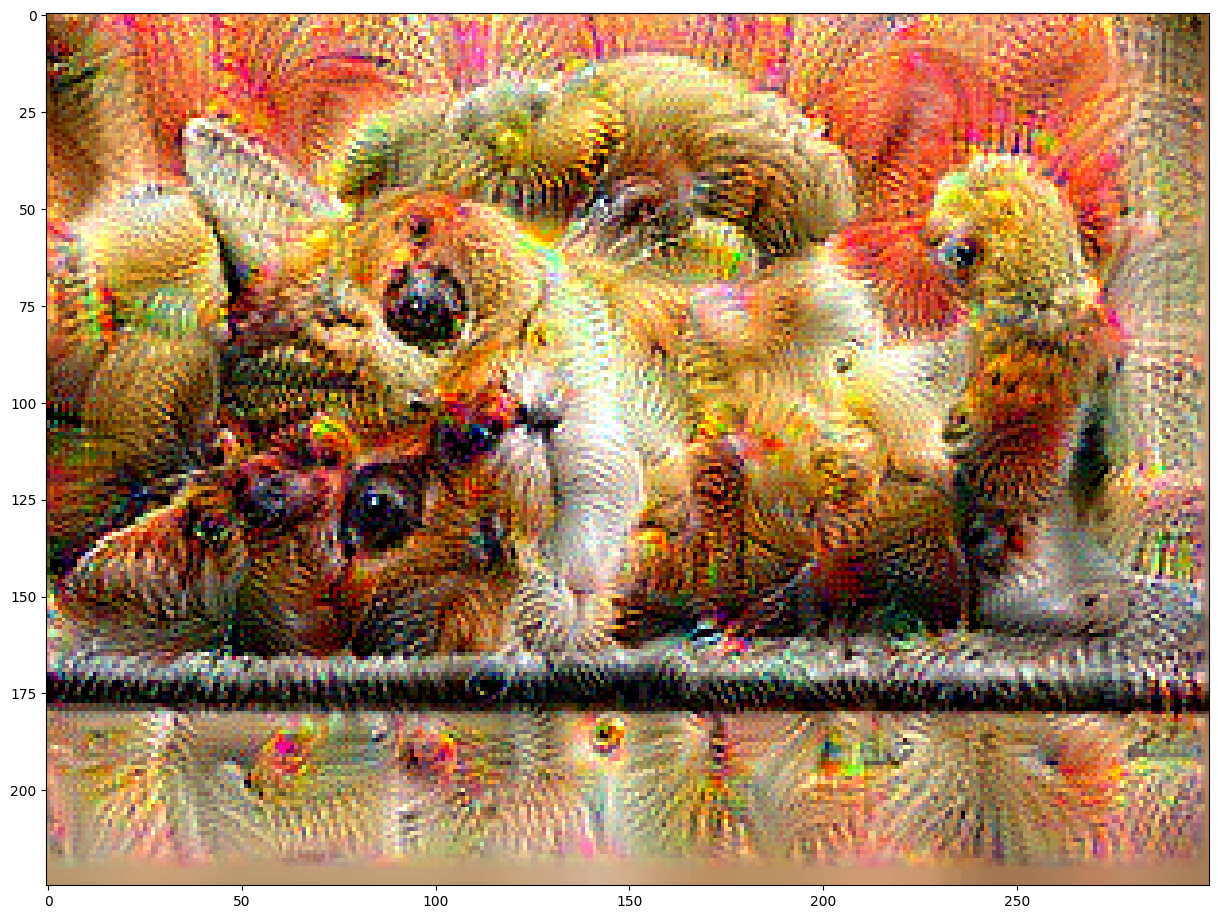

epoca 1800, loss2.646425247192383


In [120]:
executar_deep_dream(modelo_deep_dream, imagem, 2000, 0.001)